In [8]:
import numpy as np 
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule, MaskedNeuralRNNModule

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = MushroomBodyDataset()

print(f'Datum shape for input and output is (timesteps, neurons): {dataset[0]["dan"].shape}')
# dataset.data[0]

Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


In [3]:
num_samples = len(dataset.data)
train_percentage, val_percentage = 0.6, 0.2
test_percentage = 1 - train_percentage - val_percentage

lengths = [
    int(train_percentage * num_samples), 
    int(val_percentage * num_samples),
    int(test_percentage * num_samples),
]

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5400
Val dataset size: 1800
Test dataset size: 1800


# Hyperparams

In [115]:
hparams = {
    'batch_size': 8,
    'lr': 0.00005,
    'max_epochs': 20,
    'min_epochs': 1
}

# Create Dataloaders

In [70]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Load Masks

In [71]:
import matplotlib.pyplot as plt

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

In [72]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8]):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)


    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    plt.xlabel('Source')
    plt.ylabel('Target')

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

In [73]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

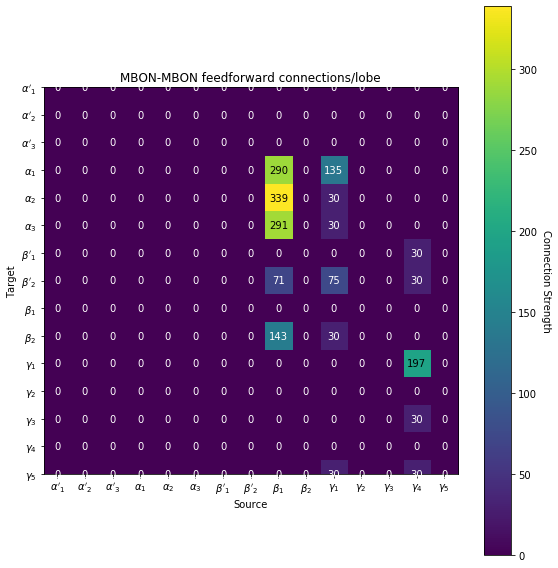

In [74]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

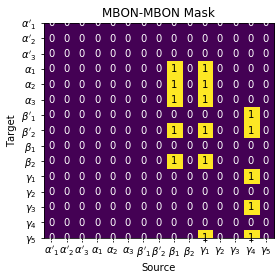

In [75]:
mbon_mask = torch.from_numpy((mbon2mbon_connectome > 0)*1.0)
plot_matrix(
    mbon_mask, 
    greek_lobes, 
    'MBON-MBON Mask',
    size=[4,4]
)

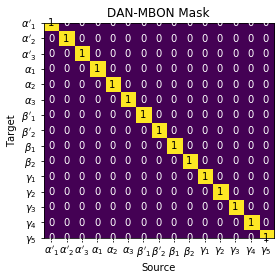

In [76]:
dan_mask = torch.from_numpy(np.diag(np.ones(15)))
plot_matrix(
    dan_mask, 
    greek_lobes, 
    'DAN-MBON Mask',
    size=[4,4]
)

# Instantiate Model

In [116]:
model = MaskedNeuralRNNModule(
    input_mask=dan_mask,
    hidden_mask=mbon_mask,
    lr=hparams['lr']
)

In [117]:
batch = next(iter(train_dataloader))

In [118]:
# Check that the forward pass does what I expect
output = model(batch['dan'])
output.shape

torch.Size([8, 10, 15])

# Lets Try Train

In [119]:
logger = TensorBoardLogger("tb_logs", name="masked_rnn", default_hp_metric=False)

In [120]:
logger.log_hyperparams(hparams)

In [121]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [122]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type            | Params
---------------------------------------------
0 | rnn      | MaskedNeuralRNN | 930   
1 | loss_fcn | MSELoss         | 0     
---------------------------------------------
480       Trainable params
450       Non-trainable params
930       Total params
0.004     Total estimated model params size (MB)


Epoch 0:  75%|███████▌  | 675/900 [00:12<00:04, 55.47it/s, loss=0.0495, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 675/900 [00:10<00:03, 66.34it/s, loss=0.0334, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 675/900 [00:09<00:03, 70.36it/s, loss=0.023, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 675/900 [00:09<00:03, 74.84it/s, loss=0.0162, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4:  75%|███████▌  | 675/900 [00:08<00:02, 80.28it/s, loss=0.0121, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████▌  | 675/900 [00:08<00:02, 79.14it/s, loss=0.00971, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6:  75%|███████▌  | 675/900 [00:08<00:02, 78.54it/s, loss=0.00853, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 7:  75%|███████▌  | 675/900 [00:08<00:02, 79.81it/s, loss=0.00804, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 8:  75%|███████▌  | 675/900 [00:08<00:02, 79.32it/s, loss=0.00788, v_num=4]
Validating: 0it [00

# Visualise the trained weights

In [127]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    return m / m.max()

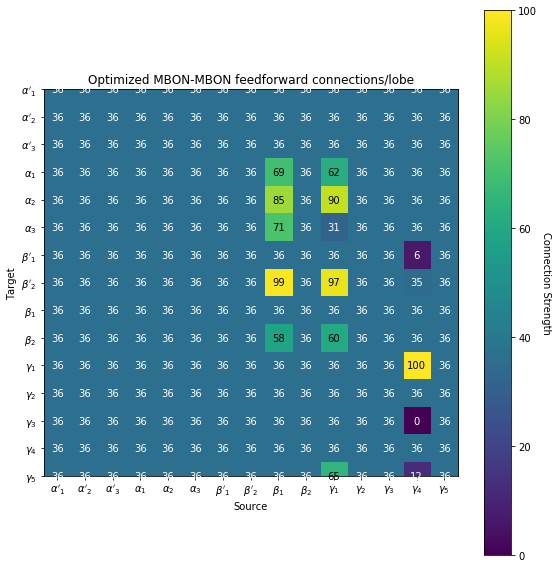

In [129]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_hh.weight.detach().numpy().T) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

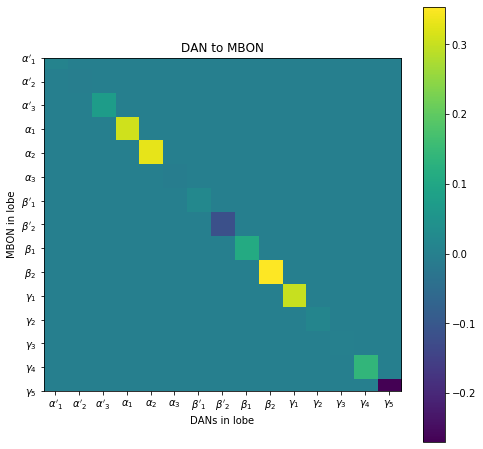

In [86]:
plt.figure(figsize=[8,8])
plt.imshow(model.rnn.W_xh.weight.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.xticks(range(0,15), greek_lobes)
plt.yticks(range(0,15), greek_lobes)

plt.title('DAN to MBON')
plt.xlabel('DANs in lobe')
plt.ylabel('MBON in lobe')
plt.show()

In [90]:
 model.eval()

MaskedNeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [124]:
batch = next(iter(train_dataloader))
output = model(batch['dan'])

print(output.shape)

torch.Size([8, 10, 15])


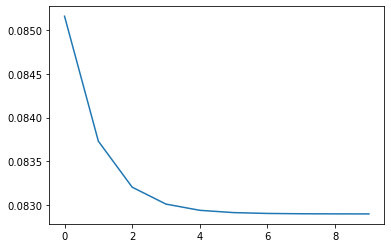

In [125]:
plt.plot(output[4,:,1].detach().numpy() )

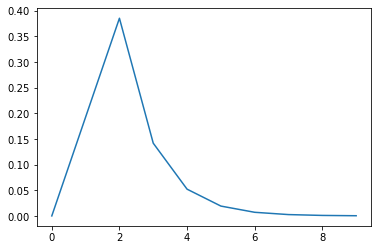

In [126]:
plt.plot(batch['mbon'][0,:,0])